In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
import glob

In [3]:
img_directory=""
mask_directory=""
size=256
num_img=999

In [4]:
image_names=glob.glob("/content/gdrive/MyDrive/data/train/images/*.png")

image_names.sort()

print(len(image_names))
image_names_subset=image_names[0:num_img]
images=[cv2.imread(img,0) for img in image_names_subset]
images=[cv2.resize(img,(256,256)) for img in images]
image_dataset=np.array(images)
print(image_dataset.shape)

image_dataset=np.expand_dims(image_dataset, axis=3)

699
(699, 256, 256)


In [5]:
mask_names=glob.glob("/content/gdrive/MyDrive/data/train/annotations/*.png")

mask_names.sort()
mask_names_subset=mask_names[0:num_img]
masks=[cv2.imread(mask,0) for mask in mask_names_subset]
masks=[cv2.resize(mask,(256,256)) for mask in masks]
mask_dataset=np.array(masks)
mask_dataset=np.expand_dims(mask_dataset, axis=3)

In [6]:
image_names=glob.glob("/content/gdrive/MyDrive/data/test/images/*.png")
image_names.sort()

print(len(image_names))
image_names_subset=image_names[0:num_img]
images=[cv2.imread(img,0) for img in image_names_subset]
images=[cv2.resize(img,(256,256)) for img in images]
image_dataset=np.array(images)
print(image_dataset.shape)

image_dataset=np.expand_dims(image_dataset, axis=3)


101
(101, 256, 256)


In [7]:
mask_names=glob.glob("/content/gdrive/MyDrive/data/test/annotations/*.png")

mask_names.sort()
mask_names_subset=mask_names[0:num_img]
masks=[cv2.imread(mask,0) for mask in mask_names_subset]
masks=[cv2.resize(mask,(256,256)) for mask in masks]
mask_dataset=np.array(masks)
mask_dataset=np.expand_dims(mask_dataset, axis=3)

In [8]:
image_names=glob.glob("/content/gdrive/MyDrive/data/val/images/*.png")

image_names.sort()

print(len(image_names))
image_names_subset=image_names[0:num_img]
images=[cv2.imread(img,0) for img in image_names_subset]
images=[cv2.resize(img,(256,256)) for img in images]
image_dataset=np.array(images)
print(image_dataset.shape)

image_dataset=np.expand_dims(image_dataset, axis=3)

199
(199, 256, 256)


In [9]:
mask_names=glob.glob("/content/gdrive/MyDrive/data/val/annotations/*.png")

mask_names.sort()
mask_names_subset=mask_names[0:num_img]
masks=[cv2.imread(mask,0) for mask in mask_names_subset]
masks=[cv2.resize(mask,(256,256)) for mask in masks]
mask_dataset=np.array(masks)
mask_dataset=np.expand_dims(mask_dataset, axis=3)

In [10]:
mask_dataset.shape

(199, 256, 256, 1)

In [11]:
image_dataset=image_dataset/256
mask_dataset=mask_dataset/256

In [12]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(image_dataset,mask_dataset, test_size=.2, random_state=42)

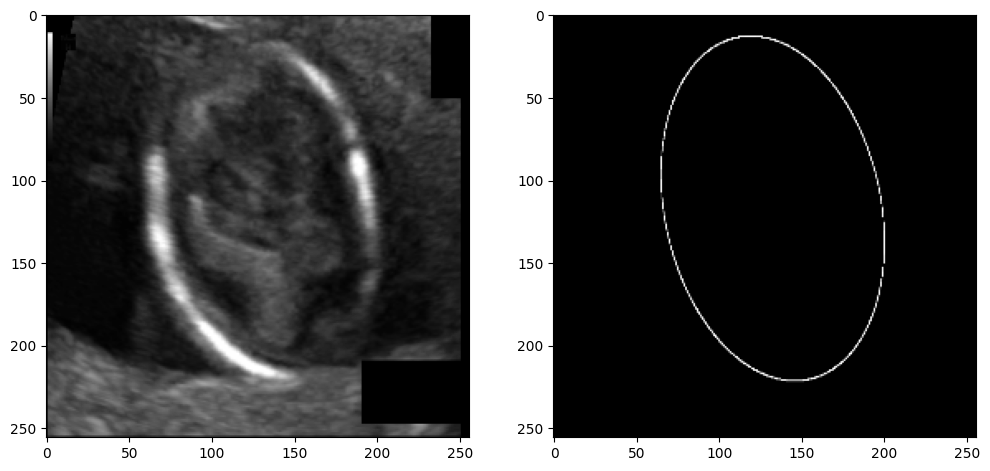

In [13]:
import random
image_number=random.randint(0,len(X_train))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0],cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap="gray")
plt.show()

In [14]:
X_train[image_number,:,:,0].shape

(256, 256)

In [15]:
!pip install keras

In [16]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose

In [17]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPooling2D, Concatenate, Input, BatchNormalization, Dropout, Lambda

In [18]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose

In [19]:
def conv_block(input, num_filters):
    x=Conv2D(num_filters,3,padding="same")(input)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)


    x=Conv2D(num_filters,3,padding="same")(x)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    return x

In [20]:
def encoder_block(input, num_filters):
    x=conv_block(input,num_filters)
    p=MaxPooling2D((2,2))(x)

    return x,p




def decoder_block(input,skip_feature, num_filters):
    x=Conv2DTranspose(num_filters,(2,2),strides=2, padding="same")(input)
    x=Concatenate()([x,skip_feature])
    x=conv_block(x,num_filters)
    return x

In [21]:
def build_unet(input_shape, n_classes):
    inputs=Input(input_shape)

    s1,p1=encoder_block(inputs,64)
    s2,p2=encoder_block(p1,128)
    s3,p3=encoder_block(p2,256)
    s4,p4=encoder_block(p3,512)


    b1=conv_block(p4,1024) # bridge


    d1=decoder_block(b1,s4,512)
    d2=decoder_block(d1,s3,256)
    d3=decoder_block(d2, s2,128)
    d4=decoder_block(d3,s1,64)

    if n_classes==1:
        activation="sigmoid"

    else:
        activation="softmax"



    outputs=Conv2D(n_classes,1,padding="same",activation=activation)(d4)


    model=Model(inputs,outputs,name="U-Net")

    return model

In [22]:
Img_height=image_dataset.shape[1]
Img_width=image_dataset.shape[2]
Img_channel=image_dataset.shape[3]
input_shape=(Img_height,Img_width,Img_channel)

In [23]:
Img_height

256

In [24]:
model=build_unet(input_shape,n_classes=1)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization[0][0

In [25]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=["accuracy"])

In [26]:
history=model.fit(X_train,y_train,
                 batch_size=3,
                 verbose=1,
                 epochs=3,
                 validation_data=(X_test,y_test),
                 shuffle=False)

Epoch 1/3
53/53 [==============================] - 53s 267ms/step - loss: 0.1880 - accuracy: 0.9825 - val_loss: 0.5122 - val_accuracy: 0.9884
Epoch 2/3
53/53 [==============================] - 11s 204ms/step - loss: 0.0848 - accuracy: 0.9890 - val_loss: 0.2808 - val_accuracy: 0.9884
Epoch 3/3
53/53 [==============================] - 11s 214ms/step - loss: 0.0695 - accuracy: 0.9890 - val_loss: 0.1449 - val_accuracy: 0.9884


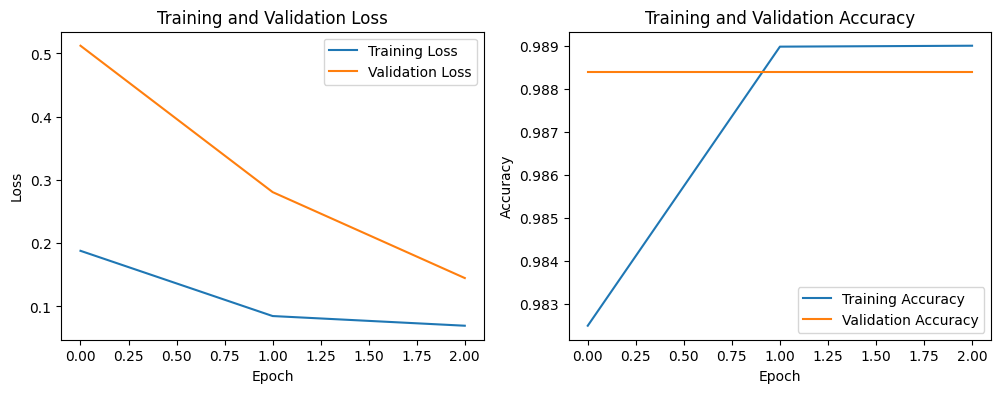

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training and validation loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training and validation accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

1/1 [==============================] - 0s 449ms/step


<ipython-input-28-a011813cf604>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221)
<ipython-input-28-a011813cf604>:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(222)
<ipython-input-28-a011813cf604>:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(223)


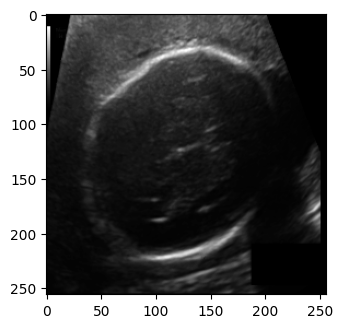

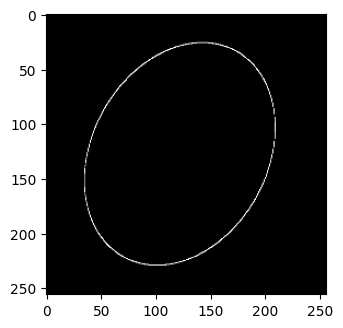

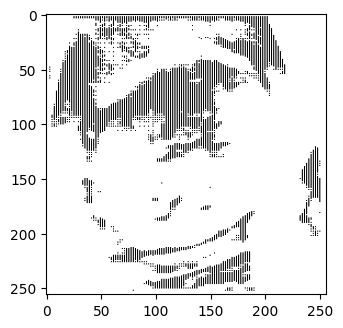

In [28]:
thrshold=0
test_img_number=random.randint(0,len(X_test))
test_img=X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_image_input=np.expand_dims(test_img,0)
prediction=(model.predict(test_image_input)[0,:,:,:]>.1).astype(np.uint8)


plt.figure(figsize=(16,8))
plt.title("testing Image")
plt.subplot(221)
plt.imshow(test_img[:,:,:],cmap='gray')

plt.figure(figsize=(16,8))
plt.title("true value")
plt.subplot(222)
plt.imshow(ground_truth[:,:,:],cmap='gray')


plt.figure(figsize=(16,8))
plt.title("predicted")
plt.subplot(223)
plt.imshow(prediction,cmap='gray')
plt.show()

In [29]:
predict=prediction*255

In [30]:
X_test.shape[0]

40

In [31]:
image_dataset.shape

(199, 256, 256, 1)

In [32]:
predicts=[]
masks=[]

def prediction(image_dataset, mask_dataset):
    for i in range(image_dataset.shape[0]):
        test_img=image_dataset[i]
        ground_truth=mask_dataset[i]
        test_image_input=np.expand_dims(test_img,0)
        predict=(model.predict(test_image_input)[0,:,:,:]>.141).astype(np.uint8)
        masks.append(ground_truth)
        predicts.append(predict)

    return predicts, masks

In [33]:
predicts, masks=prediction(X_test,y_test)

1/1 [==============================] - 0s 20ms/step


In [34]:
def mse(img1, img2):
   h, w = img1.shape
   diff = cv2.subtract(img1, img2)
   err = np.sum(diff**2)
   mse = err/(float(h*w))
   return mse, diff

In [35]:
def prediction(image_dataset, mask_dataset):
    predicts = []
    masks = []

    for i in range(image_dataset.shape[0]):
        test_img = image_dataset[i]
        ground_truth = mask_dataset[i]
        test_image_input = np.expand_dims(test_img, 0)


In [36]:
def prediction(image_dataset, mask_dataset):
    predicts = []
    masks = []
    for i in range(image_dataset.shape[0]):
        test_img = image_dataset[i]
        ground_truth = mask_dataset[i]
        test_image_input = np.expand_dims(test_img, 0)
        predict = (model.predict(test_image_input)[0, :, :, :] > 0.141).astype(np.uint8)

        # Check if predict is None or an empty array
        if predict is None or predict.size == 0:
            print(f"Warning: model.predict returned None or an empty array for image {i}")
            continue

        predicts.append(predict)
        masks.append(ground_truth)

    return predicts, masks

In [37]:
ERROR=[]
def MSE(masks, predicts):
    masks=[np.asarray(mask, np.float64) for mask in masks]
    masks=[img[:,:,0] for img in masks]


    preds=[np.asarray(pred, np.float64) for pred in predicts]
    preds=[img[:,:,0] for img in preds ]



    for mask , pred in zip(masks, preds):
        error, diff=mse(mask,pred)
        ERROR.append(error)

In [38]:
MSE(X_test,y_test)

In [39]:
predicts = np.array(predicts)
predicts.shape

(40, 256, 256, 1)

(<Axes: >, <matplotlib.image.AxesImage at 0x7e37d8ec5630>)

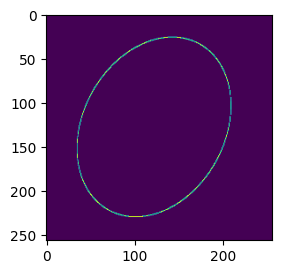

In [40]:
plt.subplot(121),plt.imshow(ground_truth[:,:,:])

In [41]:
bgr_img=test_image_input

In [42]:
bgr_img=predicts

In [43]:
bgr_img.dtype

dtype('uint8')

In [44]:
y_pred=model.predict(X_test)
y_pred_threshold=y_pred>0.5

2/2 [==============================] - 29s 8s/step


In [45]:
from tensorflow.keras.metrics import MeanIoU

In [46]:
n_classes=2
Iou_keras=MeanIoU(num_classes=n_classes)
Iou_keras.update_state(y_pred_threshold,y_test)
print("mean=",Iou_keras.result().numpy() )

mean= 1.0


In [47]:
y_pred[7].shape

(256, 256, 1)

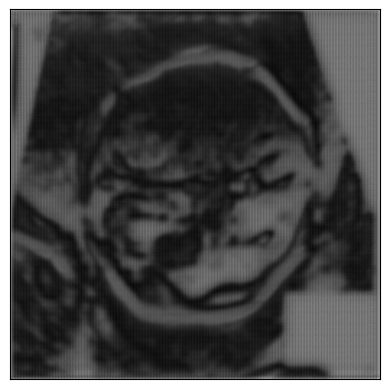

In [48]:
plt.imshow(y_pred[7], cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

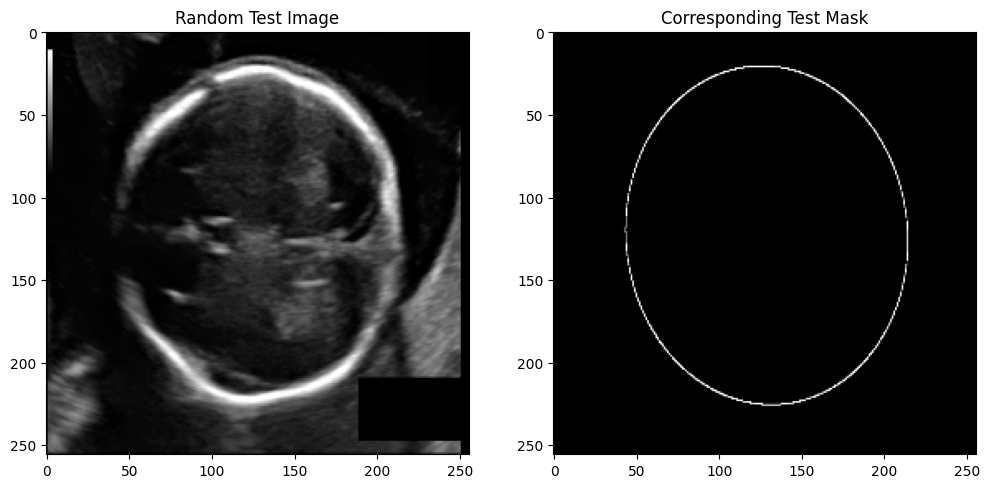

In [49]:
import random
import matplotlib.pyplot as plt

# Generate a random index for the testing dataset
random_index = random.randint(0, len(X_test) - 1)

# Retrieve the random image and its corresponding mask from the testing dataset
random_image = X_test[random_index]
random_mask = y_test[random_index]

# Plot the random image and its mask
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(random_image[:, :, 0], cmap='gray')
plt.title('Random Test Image')
plt.subplot(122)
plt.imshow(random_mask[:, :, 0], cmap='gray')
plt.title('Corresponding Test Mask')
plt.show()

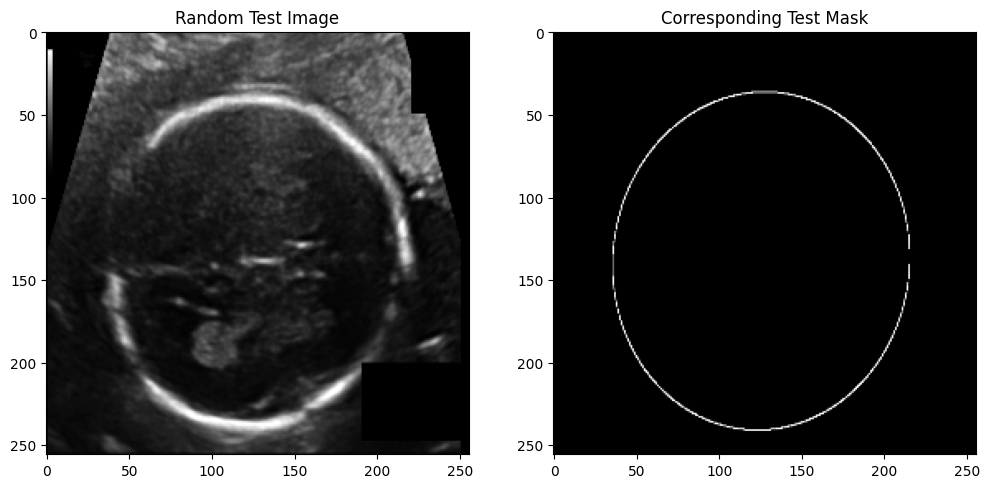

Traceback (most recent call last):
  File "<ipython-input-66-fb0547141796>", line 31, in test_random_image_display
    self.assertEqual(random_image.shape, desired_shape)
  File "/usr/lib/python3.10/unittest/case.py", line 845, in assertEqual
    assertion_func(first, second, msg=msg)
  File "/usr/lib/python3.10/unittest/case.py", line 1062, in assertTupleEqual
    self.assertSequenceEqual(tuple1, tuple2, msg, seq_type=tuple)
  File "/usr/lib/python3.10/unittest/case.py", line 1033, in assertSequenceEqual
    self.fail(msg)
  File "/usr/lib/python3.10/unittest/case.py", line 675, in fail
    raise self.failureException(msg)
AssertionError: Tuples differ: (256, 256, 1) != (256, 256, 3)

First differing element 2:
1
3

- (256, 256, 1)
?            ^

+ (256, 256, 3)
?            ^

F

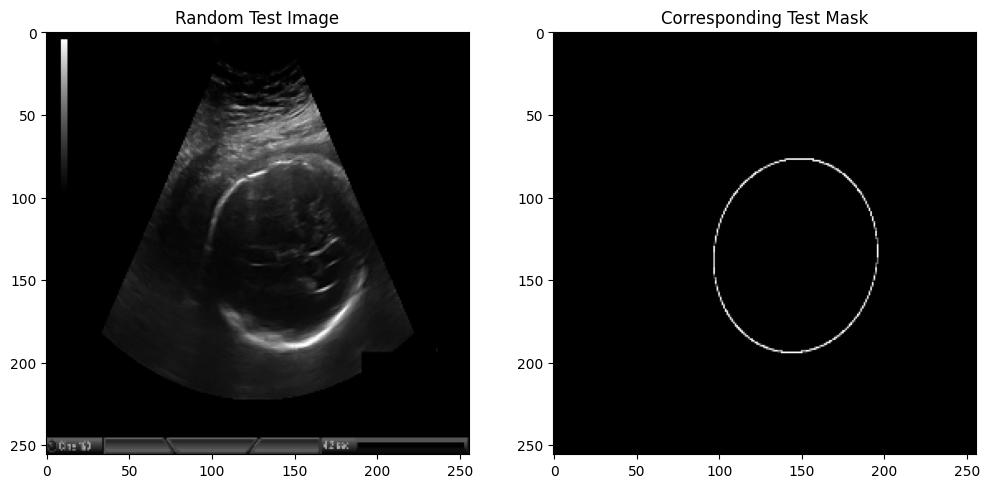

.
FAIL: test_random_image_display (__main__.MyCodeUnitTest)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-66-fb0547141796>", line 38, in test_random_image_display
    raise e  # Re-raise the exception to mark the test as failed
  File "<ipython-input-66-fb0547141796>", line 31, in test_random_image_display
    self.assertEqual(random_image.shape, desired_shape)
AssertionError: Tuples differ: (256, 256, 1) != (256, 256, 3)

First differing element 2:
1
3

- (256, 256, 1)
?            ^

+ (256, 256, 3)
?            ^


----------------------------------------------------------------------
Ran 2 tests in 0.843s

FAILED (failures=1)


In [66]:
import unittest
import random
import matplotlib.pyplot as plt

class MyCodeUnitTest(unittest.TestCase):
    def test_random_image_display(self):
        try:
            height = 256  # Replace with the actual height of your image
            width = 256  # Replace with the actual width of your image
            channels = 3  # Replace with the actual number of channels in your image
            desired_shape = (height, width, channels)

            # Generate a random index for the testing dataset
            random_index = random.randint(0, len(X_test) - 1)

            # Retrieve the random image and its corresponding mask from the testing dataset
            random_image = X_test[random_index]
            random_mask = y_test[random_index]

            # Plot the random image and its mask
            plt.figure(figsize=(12, 6))
            plt.subplot(121)
            plt.imshow(random_image[:, :, 0], cmap='gray')
            plt.title('Random Test Image')
            plt.subplot(122)
            plt.imshow(random_mask[:, :, 0], cmap='gray')
            plt.title('Corresponding Test Mask')
            plt.show()

            # Add assertions to verify the correctness of the displayed image and mask
            self.assertEqual(random_image.shape, desired_shape)
            self.assertEqual(random_image.dtype, np.uint8)

            # You can add more assertions to validate other aspects of the displayed image and mask

        except Exception as e:
            traceback.print_exc()  # Print the traceback if an exception occurs
            raise e  # Re-raise the exception to mark the test as failed

if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)

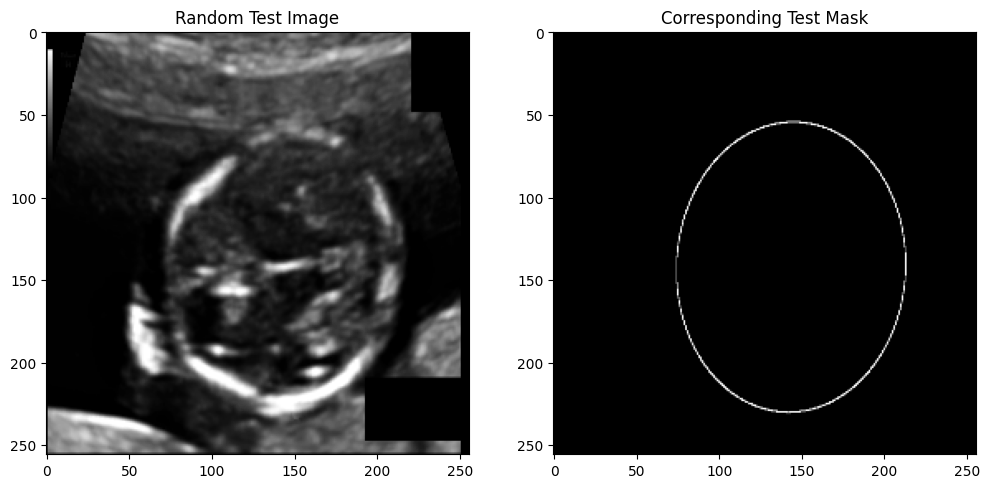

.

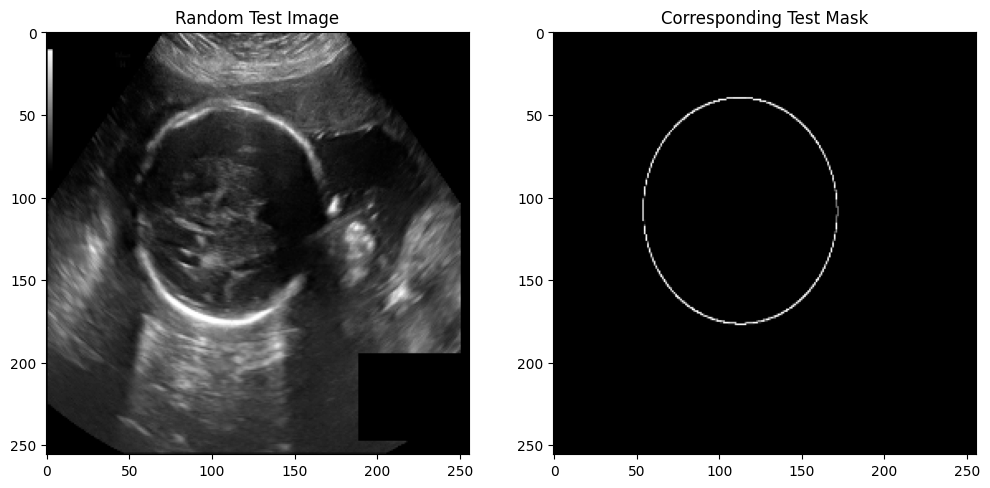

.
----------------------------------------------------------------------
Ran 2 tests in 0.845s

OK


In [65]:
import unittest
import random
import matplotlib.pyplot as plt
import numpy as np

class UnitTest(unittest.TestCase):
    def test_random_image_display(self):
        try:
            height = 256
            width = 256
            desired_shape = (height, width, 1)

            # Generate a random index for the testing dataset
            random_index = random.randint(0, len(X_test) - 1)

            # Retrieve the random image and its corresponding mask from the testing dataset
            random_image = X_test[random_index]
            random_mask = y_test[random_index]

            # Convert the random image to uint8
            random_image = (random_image * 255).astype(np.uint8)

            # Plot the random image and its mask
            plt.figure(figsize=(12, 6))
            plt.subplot(121)
            plt.imshow(random_image[:, :, 0], cmap='gray')
            plt.title('Random Test Image')
            plt.subplot(122)
            plt.imshow(random_mask[:, :, 0], cmap='gray')
            plt.title('Corresponding Test Mask')
            plt.show()

            self.assertEqual(random_image.shape, desired_shape)
            self.assertEqual(random_image.dtype, np.uint8)



        except Exception as e:
            traceback.print_exc()
            raise e

if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)